In [1]:
import os
import tarfile
from six.moves import urllib
import numpy as np

PS_PATH = os.path.join("datasets")
PS_URL = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv'
POP_URL = 'https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?dataView=1&currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D'

def fetch_data(url, path, name):
    if not os.path.isdir(path):
        os.makedirs(path)
    csv_path = os.path.join(path, name)
    urllib.request.urlretrieve(url, csv_path)


In [2]:
fetch_data(PS_URL,PS_PATH, 'PS.csv')

In [3]:
fetch_data(POP_URL,PS_PATH,'test.csv')

In [4]:
import pandas as pd

def load_data(path,name):
    csv_path = os.path.join(path, name)
    return pd.read_csv(csv_path)

In [5]:
PS_df = load_data(PS_PATH,"PS.csv")

In [6]:
PS_df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [7]:
PS_df.shape

(5495, 14)

In [8]:
PS_df.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                      213
age                        244
gender                       1
race                       556
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       259
body_camera                  0
dtype: int64

In [9]:
# PS_df['count']=np.ones((PS_df.shape[0]))

# Race

There are 549 data missing for race, so I decide to directly drop those data instead of imputing. 

In [10]:
POP_race_df = pd.read_csv('datasets/pop_race_data.csv',sep=',').set_index('Location')
POP_race_df.head(5)

,White,Black,Hispanic,American Indian/Alaska Native,Asian,Native Hawaiian/Other Pacific Islander,Two Or More Races,Total
Location,,,,,,,,
United States,192117000,38655700,58483600,2082800.0,17844800.0,519500.0,8795000,318498500
Alabama,3115600,1257300,204800,19000.0,63800.0,NaN,90700,4752600
Alaska,426100,20700,50200,110300.0,43200.0,7400.0,51100,709100
Arizona,3815100,297000,2213600,271900.0,227200.0,12000.0,167400,7004300
Arkansas,2110400,436900,224900,17000.0,44200.0,8200.0,79700,2921300


In [11]:
POP_race_df.rename(columns={'White':'W',
                          'Black':'B',
                          'Hispanic':'H',
                      'American Indian/Alaska Native':'N',
                      'Asian':'A'}, 
                 inplace=True)

In [12]:
POP_race_df.head(5)

,W,B,H,N,A,Native Hawaiian/Other Pacific Islander,Two Or More Races,Total
Location,,,,,,,,
United States,192117000,38655700,58483600,2082800.0,17844800.0,519500.0,8795000,318498500
Alabama,3115600,1257300,204800,19000.0,63800.0,NaN,90700,4752600
Alaska,426100,20700,50200,110300.0,43200.0,7400.0,51100,709100
Arizona,3815100,297000,2213600,271900.0,227200.0,12000.0,167400,7004300
Arkansas,2110400,436900,224900,17000.0,44200.0,8200.0,79700,2921300


In [13]:
# only consider major races
Death_count_race = PS_df.groupby('race')['race'].count().sort_values().to_frame().drop(index='O')
Death_count_race.columns = ['death']
Death_count_race

,death
race,
N,78
A,94
H,910
B,1306
W,2503


In [14]:
Death_count_race['ratio per 100k population'] = [Death_count_race.loc[r]['death']/
                                                 POP_race_df.loc['United States'][r]*100000 
                                                for r in Death_count_race.index]

In [15]:
Death_count_race.sort_values(by='ratio per 100k population')

,death,ratio per 100k population
race,,
A,94,0.526764
W,2503,1.302852
H,910,1.555992
B,1306,3.378544
N,78,3.744959


- In the table above, 'A' stands for 'Asians', 'W' for 'White', 'H' for 'Hispanic', 'B' for 'Black', and 'N' for 'American Indian/Alaska Native'.
- As can be seen above, aferican americans and native americans have a significant more fatal shooting rate compared to other communities.

# Gender

Ignore one missing of gender

In [16]:
Death_count_gender = PS_df.groupby('gender')['gender'].count().sort_values().to_frame()
Death_count_gender.columns = ['death']
Death_count_gender

,death
gender,
F,244
M,5250


In [17]:
POP_gender_df = pd.read_csv('datasets/pop_gender_data.csv',sep=',').set_index('Location')
POP_gender_df.rename(columns={'Male':'M',
                          'Female':'F'},
                 inplace=True)
POP_gender_df.head(5)

,M,F,Total
Location,,,
United States,155030700,161991900,317022500
Alabama,2284900,2456500,4741400
Alaska,364500,345600,710100
Arizona,3363200,3478100,6841300
Arkansas,1422700,1487200,2910000


In [18]:
Death_count_gender['ratio per 100k population'] = [Death_count_gender.loc[r]['death']/
                                                 POP_gender_df.loc['United States'][r]*100000 
                                                for r in Death_count_gender.index]
Death_count_gender.sort_values(by='ratio per 100k population')

,death,ratio per 100k population
gender,,
F,244,0.150625
M,5250,3.386426


- Men have a significant higer rate of fatal shooting.

# Age

Fill the NAs for age attribute with median value

In [19]:
PS_df.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                      213
age                        244
gender                       1
race                       556
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       259
body_camera                  0
dtype: int64

In [20]:
PS_df['age'].fillna(PS_df['age'].median(),inplace=True)

In [21]:
PS_df.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                      213
age                          0
gender                       1
race                       556
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       259
body_camera                  0
dtype: int64

In [22]:
POP_age_df = pd.read_csv('datasets/pop_age_data.csv',sep=',').set_index('Location')
POP_age_df.head()

,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,Total
Location,,,,,,,
United States,75877700,28020700,39590700.0,81990600,41897600,51121200,318498500
Alabama,1128300,419500,554400.0,1192600,646800,811000,4752600
Alaska,191100,62200,93400.0,182800,94100,85500,709100
Arizona,1706300,645900,841100.0,1702900,862200,1245900,7004300
Arkansas,728600,255200,345400.0,722800,380200,489100,2921300


In [23]:
POP_age_df.columns[0:-1].to_list()

['Children 0-18',
 'Adults 19-25',
 'Adults 26-34',
 'Adults 35-54',
 'Adults 55-64',
 '65+']

In [24]:
bins = [0,18,25,34,54,64,120]
PS_df['age_bins'] = pd.cut(PS_df['age'],bins,right=True,labels=POP_age_df.columns[0:-1].to_list())
PS_df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,age_bins
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,Adults 35-54
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,Adults 35-54
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,Adults 19-25
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,Adults 26-34
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,Adults 35-54


In [25]:
Death_count_age = PS_df.groupby('age_bins')['age_bins'].count().sort_values().to_frame()
Death_count_age.columns = ['death']
Death_count_age

,death
age_bins,
65+,173
Children 0-18,196
Adults 55-64,443
Adults 19-25,877
Adults 26-34,1512
Adults 35-54,2294


In [26]:
Death_count_age['ratio per 100k population'] = [Death_count_age.loc[r]['death']/
                                                 POP_age_df.loc['United States'][r]*100000 
                                                for r in Death_count_age.index]
Death_count_age.sort_values(by='ratio per 100k population')

,death,ratio per 100k population
age_bins,,
Children 0-18,196,0.258310
65+,173,0.338411
Adults 55-64,443,1.057340
Adults 35-54,2294,2.797882
Adults 19-25,877,3.129829
Adults 26-34,1512,3.819079


- Adults with age of 26-34 have a significant higer rate of fatal shooting.

# Armed

In [27]:
PS_df.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                      213
age                          0
gender                       1
race                       556
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       259
body_camera                  0
age_bins                     0
dtype: int64

In [28]:
PS_df['armed'].unique()

array(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', nan, 'shovel',
       'vehicle', 'hammer', 'hatchet', 'sword', 'machete', 'box cutter',
       'undetermined', 'metal object', 'screwdriver', 'lawn mower blade',
       'flagpole', 'guns and explosives', 'cordless drill', 'crossbow',
       'metal pole', 'Taser', 'metal pipe', 'metal hand tool',
       'blunt object', 'metal stick', 'sharp object', 'meat cleaver',
       'carjack', 'chain', "contractor's level", 'unknown weapon',
       'stapler', 'beer bottle', 'bean-bag gun',
       'baseball bat and fireplace poker', 'straight edge razor',
       'gun and knife', 'ax', 'brick', 'baseball bat', 'hand torch',
       'chain saw', 'garden tool', 'scissors', 'pole', 'pick-axe',
       'flashlight', 'baton', 'spear', 'chair', 'pitchfork',
       'hatchet and gun', 'rock', 'piece of wood', 'bayonet', 'pipe',
       'glass shard', 'motorcycle', 'pepper spray', 'metal rake',
       'crowbar', 'oar', 'machete and gun', 'tire iron',
 

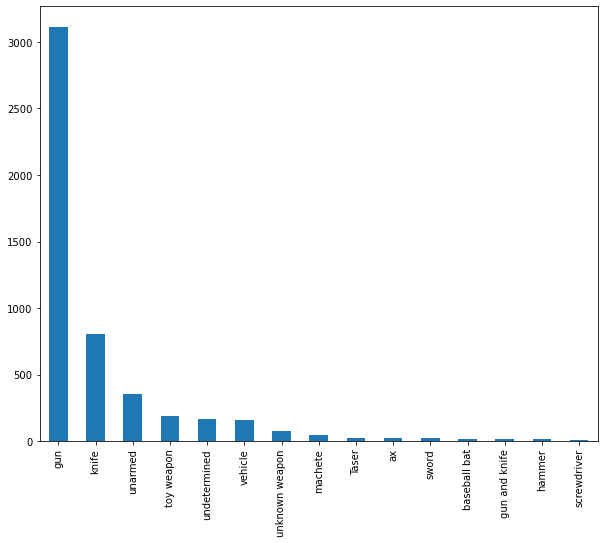

In [29]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (10,8))
PS_df['armed'].value_counts()[0:15].plot(kind='bar')
plt.show()

In [30]:
PS_df['armed'].value_counts()[0:15]

gun               3110
knife              805
unarmed            354
toy weapon         193
undetermined       167
vehicle            157
unknown weapon      79
machete             46
Taser               26
ax                  24
sword               22
baseball bat        18
gun and knife       17
hammer              16
screwdriver         13
Name: armed, dtype: int64

In [33]:
'Calculating the ratio of armed victims'
print('armed ratio:', 1-PS_df['armed'].value_counts().loc['unarmed']/PS_df.shape[0])

armed ratio: 0.9355777979981802


- From the analysis above we could see that most fatal shooting victims are carrying weapons, at around 93.6%.
- The most popular weapon is gun related.